### Importing dependencies 

In [1]:
import ray
ray.init()

2023-07-01 16:15:07,677	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.0
Ray version:,2.5.1
Dashboard:,http://127.0.0.1:8265


In [2]:
import modin.pandas as mpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')
import seaborn as sns
import missingno as msno
import category_encoders as ce
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
# from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Chossing a style ( can see the list using the code : plt.style.available
plt.style.use('default')
print("Everything imported successfully")

Everything imported successfully


### Loading the data from csv file

In [6]:
# Loading csv file
df = mpd.read_csv('Data.csv')

# Introductory EDA

In [5]:
# Checking the shape of the dataframe
df.shape

(19158, 13)

In [6]:
# Checking any 5 random rows
df.sample(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
9455,22092,city_104,0.924,Female,Has relevent experience,no_enrollment,High School,NaN,14.0,NaN,NaN,142.0,0.0
477,6283,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,Other,10.0,50-99,Pvt Ltd,206.0,0.0
14884,12364,city_28,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,12.0,50-99,Pvt Ltd,7.0,0.0
15635,3267,city_16,0.910,Male,No relevent experience,Full time course,Masters,STEM,10.0,NaN,NaN,48.0,0.0
12783,7536,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,20.0,0.0


In [7]:
# Let's get some basic informatin about the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


In [8]:
# Optimizing the memory by using appropriate data types
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

In [9]:
# Descriptive information about the data
df.describe()

,enrollee_id,city_development_index,experience,training_hours,target
count,19158.000000,18679.000000,19093.000000,18392.000000,19158.000000
mean,16875.358179,0.828951,9.928037,65.185791,0.249348
std,9616.292592,0.123334,6.505268,59.885624,0.432647
min,1.000000,0.448000,0.000000,1.000000,0.000000
25%,8554.250000,0.740000,4.000000,23.000000,0.000000
50%,16982.500000,0.903000,9.000000,47.000000,0.000000
75%,25169.750000,0.920000,16.000000,88.000000,0.000000
max,33380.000000,0.949000,20.000000,336.000000,1.000000


In [10]:
# Checking percentage of null values
print(df.isnull().mean()*100)

# Checking number of duplicate values
print("Total duplicate values :",df.duplicated().sum())

enrollee_id                0.000000
city                       0.000000
city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
dtype: float64
Total duplicate values : 0


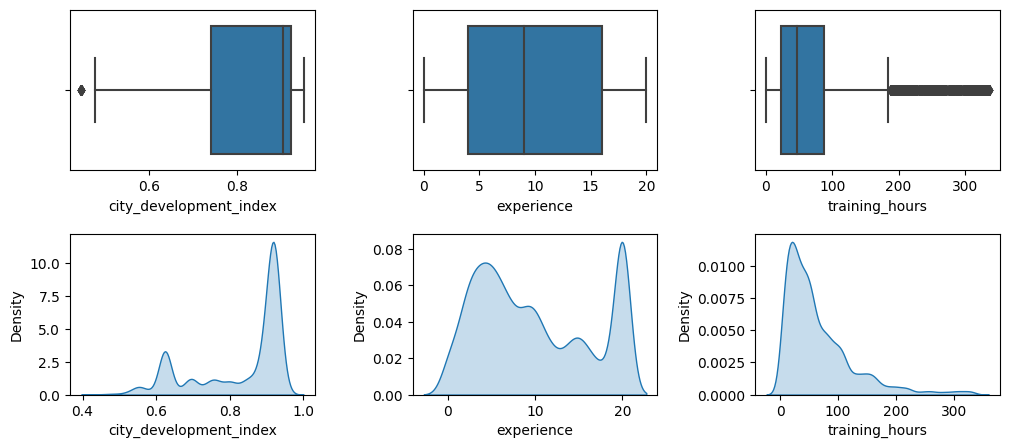

In [11]:
# Let's check if there are any outliers in the numerical columns
fig,ax = plt.subplots(2,3,figsize=(12,5))

sns.boxplot(x = df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = df['experience'],ax = ax[0][1])
sns.boxplot(x = df['training_hours'],ax = ax[0][2])

sns.kdeplot(data = df['city_development_index'],ax = ax[1][0],fill=True)
sns.kdeplot(data = df['experience'],ax = ax[1][1],fill=True)
sns.kdeplot(data = df['training_hours'],ax = ax[1][2],fill=True)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

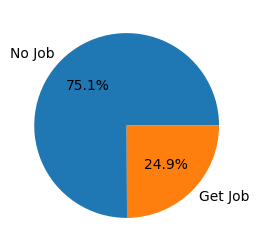

In [12]:
# Plot a pie chart 0 -> No job and 1 -> Get job
fig,ax = plt.subplots(figsize = (3,3))

plt.pie(df['target'].value_counts(), labels=['No Job', 'Get Job'],autopct='%1.1f%%')
plt.show()

# Data Cleaning and processing

During this phase the things which we will be doing are 

1. Dropping unnecessary columns
2. Handling imbalance data
3. Dealing with missing values
4. Dealing with outliers
5. Encoding the categorical values

In [13]:
# Dropping the unnecessary columns from the dataframe
df = df.drop(['enrollee_id','city'],axis=1)
df.head(3)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0


In [14]:
print("Before duplicate values:",df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("After duplicate values:",df.duplicated().sum())

Before duplicate values: 194
After duplicate values: 0


In [ ]:
# Using pandas profiling 
prof = ProfileReport(df)
prof.to_file(output_file='Summary.html')

Since after sampling the data the overall dynamics of the entire dataset most of the times changes. So first we will train our model without dealing with imbalance and then we will compare its performance after sampling.

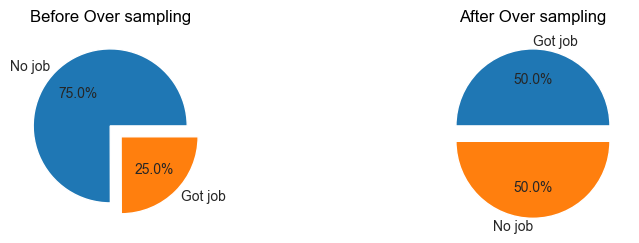

In [15]:
# Seperating the data into dependent and independent variable
y = df['target']
X = df.drop('target',axis=1)

# Creating an object of RandomOVerSampler class
rs = RandomOverSampler()
X_new,y_new = rs.fit_resample(X,y)


# Let's visualize distribution of the classes in the target variable before and after 
fig,ax = plt.subplots(1,2,figsize=(10,2.5))
ex = (0,0.2)
sns.set_style("whitegrid")

ax[0].pie(df['target'].value_counts(), labels=['No job','Got job'], autopct='%1.1f%%', explode=ex)
ax[0].set(title='Before Over sampling')
ax[1].pie(y_new.value_counts(), labels=['Got job','No job'], autopct='%1.1f%%', explode=ex)
ax[1].set(title='After Over sampling')

# show the plot
plt.show()

For the complete data processing we will be creating a pipeline, but before making a pipeling we need to explore all the techniques which we can use to process our data in most efficient way and for this we will simply create a copy of the dataframe.

In [16]:
# Creating a copy of the dataframe
New_df = pd.concat([X_new,y_new],axis=1)
temp_df = New_df.copy()
temp_df.head(3)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0


### Dealing with missing values

In order to deal with missing values we can either impute them or we can remove them. Generally for the features having percentage of missing values less than 5% it is said to remove the missing values. But in order to retain as much data as possible we will compare the effect of both removing and imputing the missing values.

In [17]:
# Let's take out features having missing value percentage less than 5% 
Less_5PER = [col for col in temp_df.columns if temp_df[col].isnull().mean()*100 <5 and temp_df[col].isnull().mean()*100>0]

# Let's create 2 copy to compare the change in distribution
remove_nan = temp_df[Less_5PER].copy()
impute_nan = temp_df[Less_5PER].copy()

In [18]:
# Dropping all the rows having column values as NaN
remove_nan.dropna(inplace=True)

# Mean imputation
impute_nan['city_development_index'].fillna(impute_nan['city_development_index'].mean(),inplace=True)
impute_nan['experience'].fillna(impute_nan['city_development_index'].mean(),inplace=True)
impute_nan['training_hours'].fillna(impute_nan['city_development_index'].mean(),inplace=True)

# Mode imputation
impute_nan['enrolled_university'].fillna(impute_nan['enrolled_university'].mode().values[0],inplace=True)
impute_nan['education_level'].fillna(impute_nan['education_level'].mode().values[0],inplace=True)

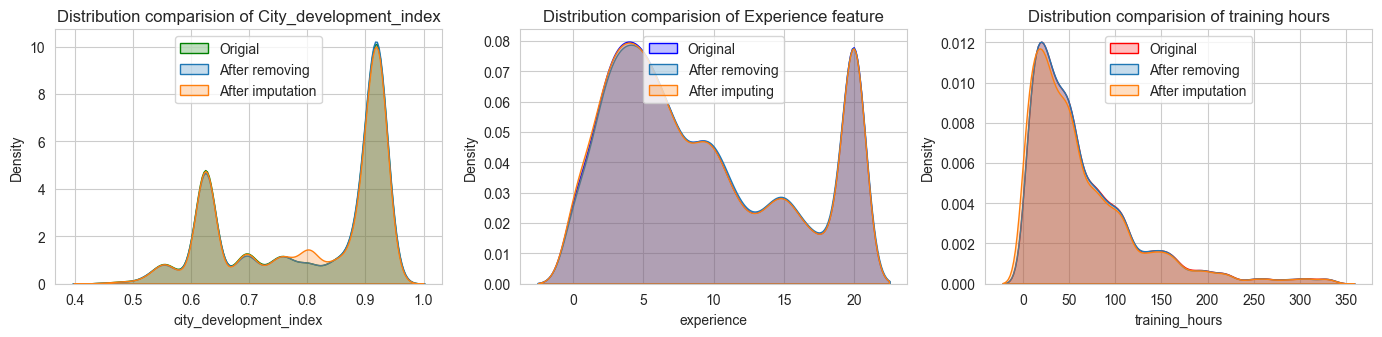

In [19]:
# Now let's visualize the distributions before and after implemnting CCA on numerical features
fig, ax = plt.subplots(1, 3, figsize=(17, 3.3))

sns.kdeplot(temp_df['city_development_index'], fill=True,ax=ax[0], color='green', label='Origial')
sns.kdeplot(remove_nan['city_development_index'], fill=True,ax=ax[0], label='After removing')
sns.kdeplot(impute_nan['city_development_index'], fill=True,ax=ax[0], label='After imputation')
ax[0].legend(loc='upper center')
ax[0].set(title='Distribution comparision of City_development_index')

sns.kdeplot(temp_df['experience'], fill=True,ax=ax[1], color='blue', label='Original')
sns.kdeplot(remove_nan['experience'], fill=True,ax=ax[1], label='After removing')
sns.kdeplot(impute_nan['experience'], fill=True,ax=ax[1], label='After imputing')
ax[1].legend(loc='upper center')
ax[1].set(title='Distribution comparision of Experience feature')

sns.kdeplot(temp_df['training_hours'], fill=True,ax=ax[2], color='red', label='Original')
sns.kdeplot(remove_nan['training_hours'], fill=True,ax=ax[2], label='After removing')
sns.kdeplot(impute_nan['training_hours'], fill=True,ax=ax[2], label='After imputation')
ax[2].legend(loc='upper center')
ax[2].set(title='Distribution comparision of training hours')

plt.show()

For the categorical columns we will check the ratio of categories before and after applying CCA

In [20]:
# For the categorical features we will check the ratio of classes before and after implementing CCA
compare_eu = pd.concat([temp_df['enrolled_university'].value_counts() / len(temp_df),
                    remove_nan['enrolled_university'].value_counts() / len(remove_nan),
                    impute_nan['enrolled_university'].value_counts()/len(impute_nan)],axis=1)

compare_eu.columns = ['Original','After removing','After imputation']
compare_eu

,Original,After removing,After imputation
no_enrollment,0.686051,0.699604,0.708292
Full time course,0.229972,0.237428,0.229972
Part time course,0.061736,0.062969,0.061736


In [21]:
compare_edu_level = pd.concat([ temp_df['education_level'].value_counts() / len(temp_df),
                        remove_nan['education_level'].value_counts() / len(remove_nan),
                        impute_nan['education_level'].value_counts()/len(impute_nan)],axis=1)

compare_edu_level.columns = ['Original','After removing','After imputation']
compare_edu_level

,Original,After removing,After imputation
Graduate,0.625720,0.640207,0.649368
Masters,0.220520,0.226554,0.220520
High School,0.097822,0.099949,0.097822
Phd,0.018412,0.018961,0.018412
Primary School,0.013879,0.014329,0.013879


From our analysis we can clearly see that for all the columns having percentage of missing values less than 5% the distribution is not changing a lot after imputation in the numerical features and for the categorical features as well the ratio is not changing a lot after imputation, thus to keep as much data as we can we will imputing the missing values instead of removing them.

Also for the other columns like Gender, major discipline, company size and company type we will be using advance imputation technique like KNN imputer in this case.

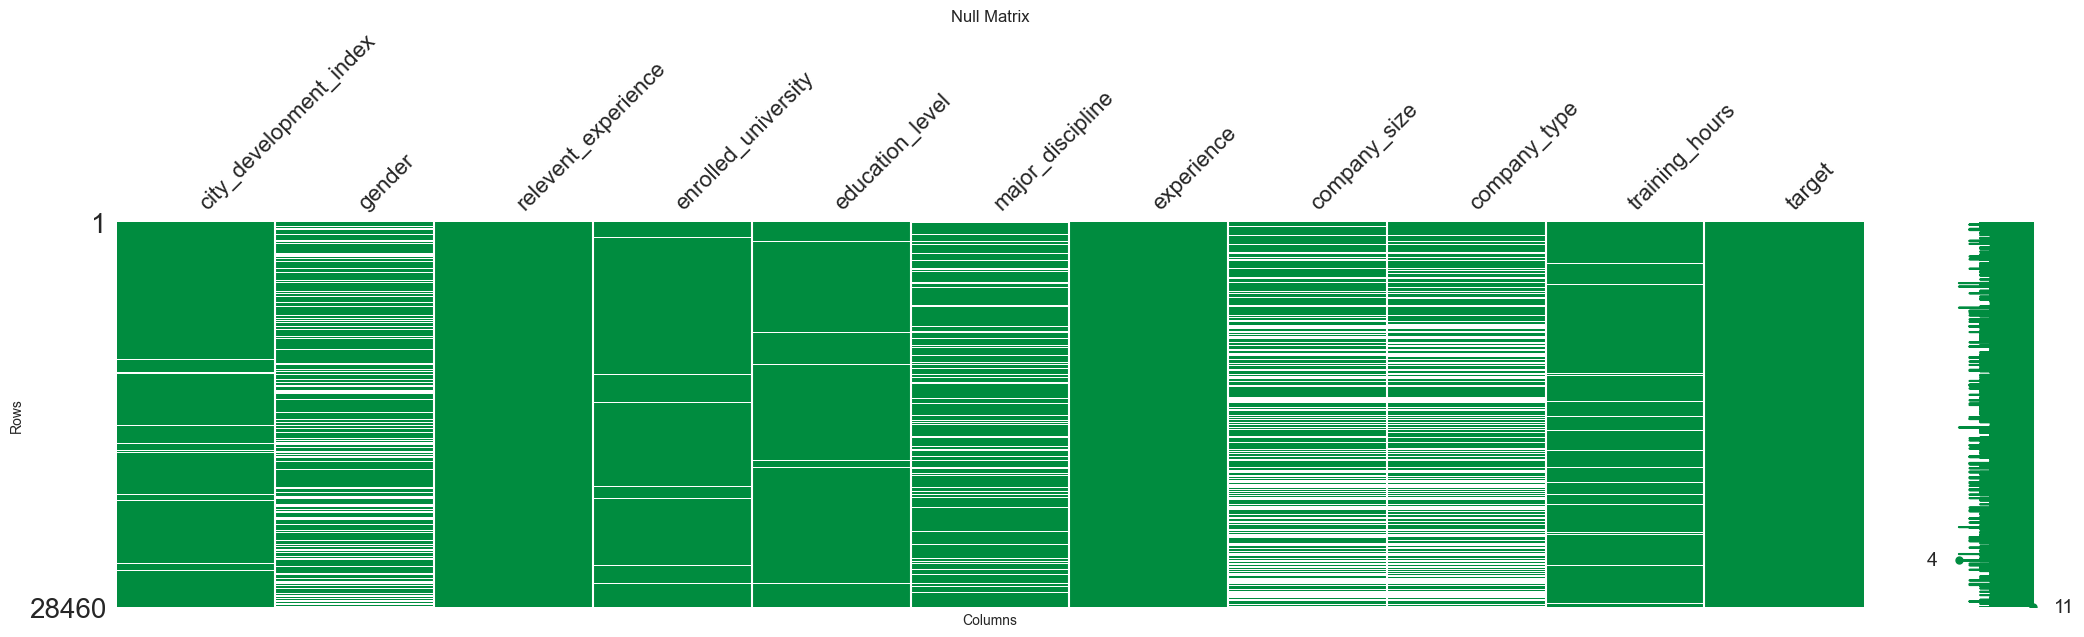

In [22]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(temp_df,figsize=(25, 5),color=(0, 0.55, 0.25))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

### Dealing with outliers

Let's now deal with the outliers. From the previous analysis we got to know that city_development_index and training_hours both had outliers and both of these features had a skewness in thier distribution. So in order to deal with the missing values we will be using the IQR method.

But since the training_hours feature have a lot of outliers so there are chances that this could also be a sort of indication of somehting important so for now we will keep these outliers in the data and will remove them later to check if there is any imporovement in the model performance.

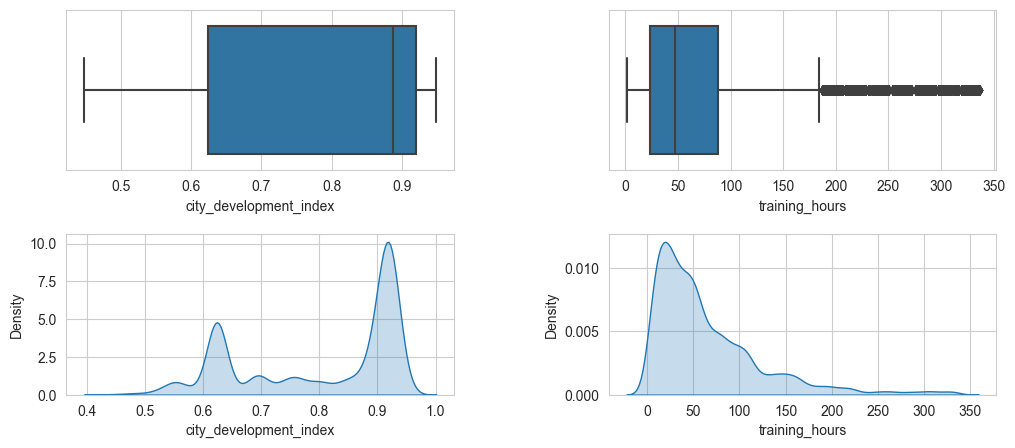

In [23]:
# Let's check if there are any outliers in the numerical columns
fig,ax = plt.subplots(2,2,figsize=(12,5))

sns.boxplot(x = temp_df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = temp_df['training_hours'],ax = ax[0][1])

sns.kdeplot(data = temp_df['city_development_index'],ax = ax[1][0],fill=True)
sns.kdeplot(data = temp_df['training_hours'],ax = ax[1][1],fill=True)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

### Dealing with categorical columns

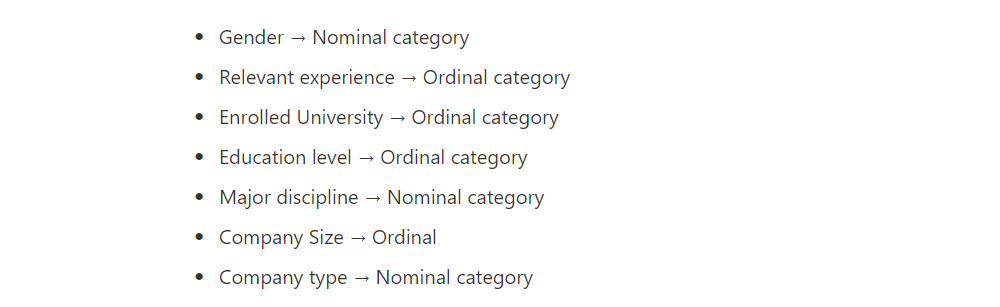

🚨 An important thing we must keep in mind is that for dealing with the nominal categorical values we can either use one hot encoding or target encoding. But the use of any of the technique is totally based on the cardinality of the column.

If there is high cardinality ➡️ Target encoding
If there is less cardinality ➡️ One hot encoding

### Feature selection/Extraction

# Creation of Pipeline

As we have explored all the techniques which we will be using to deal with misssing values, outliers and cateogircal features. We will now create a pipeline that will do all the data cleaning and processing in a streamlined process.

- First we will create a column transformer to deal with missing values ( Simple imputtation techniques )
- Then we will create a column transformer for doing ordinal and target encoding
- After doing encoding we will use KNN imputer to impute the columns which were having high missing values percentage
- Followed by this we will scale our values
- Finally we will be using a machine learning model for training

**Down below is the descirption all the change in column positions after the data will go through each and every column transformer**

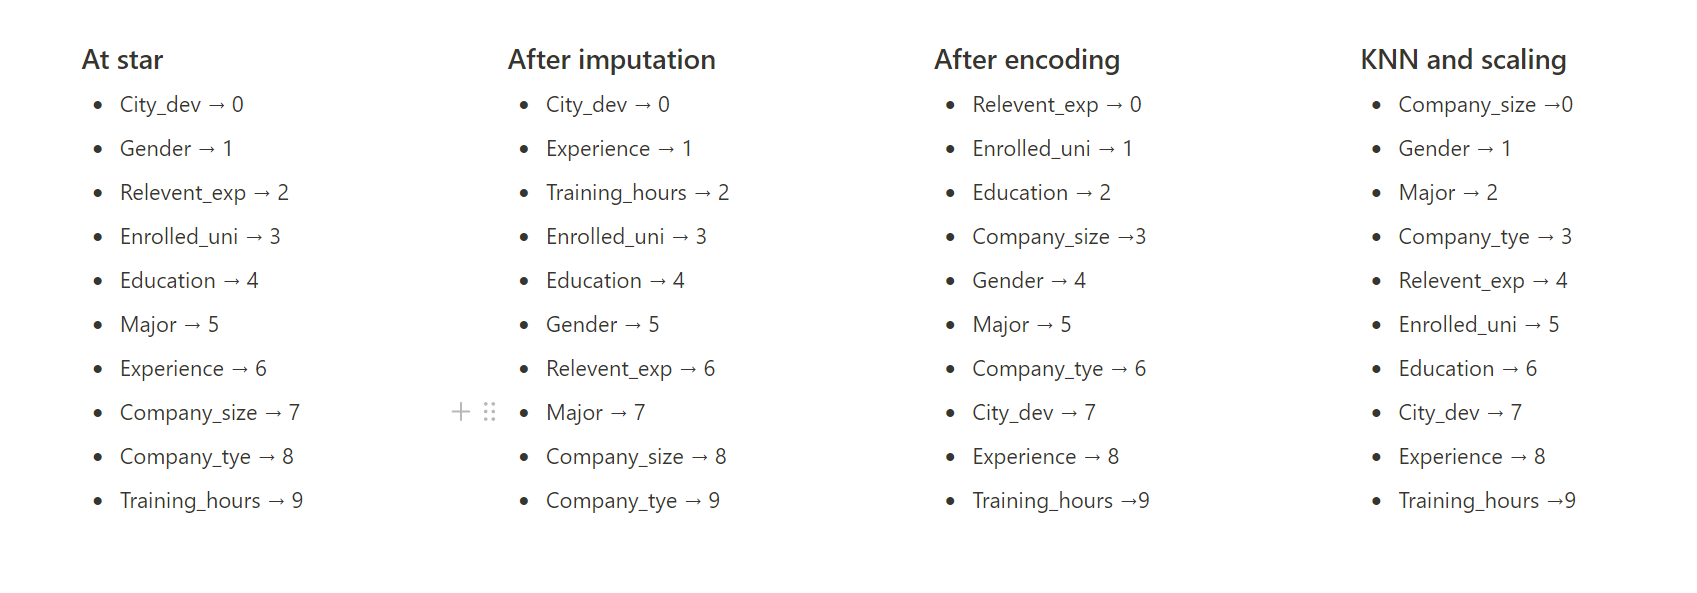

In [24]:
# Define the column transformer for imputation
Simple_impute_transformer = ColumnTransformer(transformers=[
    ('mean_imputer', SimpleImputer(strategy='mean'), [0, 6, 9]),
    ('mode_imputer', SimpleImputer(strategy='most_frequent'), [3, 4])        
], remainder='passthrough')

# Define the column transformer for encoding
encode_values = ColumnTransformer(transformers=[
    ('Encode_ordinal_Re', OrdinalEncoder(categories=[['No relevent experience', 'Has relevent experience']],handle_unknown='use_encoded_value', unknown_value=np.nan), [6]),
    ('Encode_ordinal_eu', OrdinalEncoder(categories=[['no_enrollment', 'Part time course', 'Full time course']],handle_unknown='use_encoded_value', unknown_value=np.nan), [3]),
    ('Encode_ordinal_el', OrdinalEncoder(categories=[['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']],handle_unknown='use_encoded_value', unknown_value=np.nan), [4]),
    ('Encode_ordinal_cs', OrdinalEncoder(categories=[['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']],handle_unknown='use_encoded_value', unknown_value=np.nan), [8]),
    ('Encode_target_gen', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [5]),
    ('Encode_target_major', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [7]),
    ('Encode_target_ct', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [9])
], remainder='passthrough')

Knn_imputer = ColumnTransformer(transformers=[
    ('Knn_Imputer', KNNImputer(n_neighbors=5, metric='nan_euclidean'), [3,4, 5, 6])
], remainder='passthrough')

# Column transformer to do feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('scale_transformer', MinMaxScaler(), [7, 8, 9])
], remainder='passthrough')

Algorithm = RandomForestClassifier(n_estimators=100)

# Define the final pipeline
pipe = Pipeline(steps=[
    ('impute_transformer', Simple_impute_transformer),
    ('encode_values', encode_values),
    ('Knn_imputer', Knn_imputer),
    ('Scaling', scaling_transformer),
    ('ML_Model', Algorithm)
])


In [25]:
# Seperating the data into dependent and independnet variable
X = New_df.drop(['target'],axis=1)
y = New_df['target']

# Let's split the data into train,test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Model training and evaluation

In [26]:
# Cleaning and processing the data using pipeline
# pipe.fit_transform(X_train,y_train)
# data = pd.DataFrame(data)
# data.shape

pipe.fit(X_train,y_train)

# Let's get predicted labels
y_pred = pipe.predict(X_test)

In [33]:
# data.reset_index(drop=True, inplace=True)
# y_train.reset_index(drop=True, inplace=True)

In [44]:
# Get the list of available models
all_models = models()

# Print the list of models
models().index.values

array(['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm', 'dummy'],
      dtype=object)

In [47]:
# initialize setup with preprocessing
clf = setup(data, target=y_train,preprocess= False,use_gpu=True)

# compare selected models
best_model = compare_models(include= ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm', 'dummy'])

,Description,Value
0,Session id,5513
1,Target,target
2,Target type,Binary
3,Original data shape,"(17076, 11)"
4,Transformed data shape,"(17076, 11)"
5,Transformed train set shape,"(11953, 11)"
6,Transformed test set shape,"(5123, 11)"
7,Categorical features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8375,0.8992,0.8715,0.8163,0.8429,0.6751,0.6767,2.2080
et,Extra Trees Classifier,0.8269,0.9074,0.8485,0.8136,0.8306,0.6538,0.6545,1.7160
lightgbm,Light Gradient Boosting Machine,0.8012,0.8529,0.8133,0.7944,0.8036,0.6024,0.6028,3.5810
dt,Decision Tree Classifier,0.7775,0.7795,0.8404,0.7466,0.7907,0.5549,0.5595,0.4610
gbc,Gradient Boosting Classifier,0.7560,0.7993,0.7339,0.7681,0.7506,0.5121,0.5127,2.0740
ada,Ada Boost Classifier,0.7477,0.7889,0.7020,0.7729,0.7356,0.4954,0.4976,1.2750
knn,K Neighbors Classifier,0.7210,0.7746,0.7605,0.7051,0.7317,0.4420,0.4435,1.1220
gpc,Gaussian Process Classifier,0.7139,0.7660,0.7086,0.7167,0.7125,0.4278,0.4279,197.0630
mlp,MLP Classifier,0.7112,0.7681,0.7026,0.7169,0.7087,0.4224,0.4236,15.8810
rbfsvm,SVM - Radial Kernel,0.6935,0.7451,0.6717,0.7028,0.6867,0.3871,0.3876,44.5920


Since we can clearly see that random forest classifier is performing the best so we will use this algorithm.

In [27]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculating precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

# Calculating recall
recall = recall_score(y_test, y_pred, average='macro')
print("Recall: ", recall)

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score: ", f1)

Accuracy:  0.8710470836261419
Precision:  0.8742822244618302
Recall:  0.8712109314811961
F1 Score:  0.8708018217937394


In [28]:
# Saving model and pickle file
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))